# **Plant Zonation Figures**

This notebook contains the code for figures plotting vegetation species occurrence along the plotted profile of the dune.

This code is at the transect level. Each transect for each site is plotted separately.

This code is also for plotting the figures for all transects within all excel sheets. It automatically saves the figure files as .png with transparent backgrounds to a folder called zonation_figures

### **Importing Libraries**

In [1]:
import pandas as pd #for data manipulation and analysis
import numpy as np #numerical operations
import matplotlib.pyplot as plt #plotting
from scipy.interpolate import CubicSpline #create cubic spline operations
import os #provides functions to interact with operating system

### **Load and clean Excel files**

In [2]:
def load_and_clean_data(file_path, sheet_name):
    files = pd.read_excel(file_path, sheet_name=sheet_name)
    
    # Extract valid elevation data
    elevation_data = files.dropna(subset=["tran_dist", "tran_ht"])
    elevation_data = elevation_data.sort_values("tran_dist").drop_duplicates(subset="tran_dist", keep="first")
    
    # Ensure 'tran_dist' is strictly increasing
    diffs = np.diff(elevation_data["tran_dist"])
    if np.any(diffs <= 0):
        print(f"Non-increasing 'tran_dist' found in {sheet_name}. Skipping this transect.")
        return None

    return elevation_data

### **Get foredune toe values**

Retrieve the foredune toe values with error handling

In [3]:
def get_toe_values(files):
    toe_in_series = files['fore_toe_in'].dropna()
    toe_sea_series = files['fore_toe_sea'].dropna()

    if toe_in_series.empty or toe_sea_series.empty:
        return None, None
    
    return toe_in_series.iloc[0], toe_sea_series.iloc[0]

### **Cubic Interpolation**

this function does the cubic interpolation on the transect data

In [4]:
def perform_interpolation(tran_dist, tran_ht, toe_in, toe_sea):
    # Inverse the y-values for interpolation
    inverse_height = -tran_ht
    cubicx = np.linspace(tran_dist.min(), tran_dist.max(), num=1001)
    spl = CubicSpline(tran_dist, inverse_height)
    cubicy = spl(cubicx)

    # Calculate relative cubic heights
    ht_at_toe_sea = spl(toe_sea)
    ht_at_toe_in = spl(toe_in)
    relative_cubicy = cubicy - min(ht_at_toe_sea, ht_at_toe_in)

    return cubicx, relative_cubicy, spl

### **Calculate Zonation Heights**

calculate the start and end heights for the zonation segments

In [5]:
def calculate_zonation_heights(files, spl, min_height):
    files['start_height'] = spl(files['start'].fillna(0))
    files['end_height'] = spl(files['end'].fillna(0))
    
    files['relative_start_height'] = files['start_height'] - min_height
    files['relative_end_height'] = files['end_height'] - min_height

### **Plotting Function**

Plotting function for the elevation profile (cubic interpolation) and species zonation


In [9]:
def plot_transect(cubicx, relative_cubicy, files, spl, min_height, color_map, sheet_name, filename, figures_folder):
    """
    Plot the transect with cubic interpolation and plant zonation, and save the figure.
    """
    import matplotlib.pyplot as plt

    # Create the plot
    plt.figure(figsize=(20, 1))  # Adjusted figure size for better view
    plt.plot(cubicx, relative_cubicy, label="Cubic Spline Interpolation", color='#16395eff', linewidth=3)

    # Plot the plant zonation segments as curves
    for _, row in files.iterrows():
        if pd.notna(row['start']) and pd.notna(row['end']):
            # Only plot if the 'type' has exactly 4 letters
            if isinstance(row['type'], str) and len(row['type']) == 4:
                # Create an array of x values between start and end
                x_vals = np.linspace(row['start'], row['end'], num=100)
                # Use the cubic spline to calculate the corresponding y values
                y_vals = spl(x_vals) - min_height
                # Plot the curve
                plt.plot(x_vals, y_vals, 
                         color=color_map.get(row['type'], 'black'),  # Default color if type not in color_map
                         linewidth=10, label=row['type'] if row['type'] not in plt.gca().get_legend_handles_labels()[1] else "")

    # Fill the area under the curve relative to 0 (adjusted y-axis)
    plt.fill_between(cubicx, relative_cubicy, 0, where=(relative_cubicy > 0), color='#ffdeabff', alpha=1, label="Area Above Lower Toe Line")

    # Plot reference lines at 0 and the height difference
    plt.axhline(y=0, color='#16395eff', linestyle='--', label='Lower Toe Line = 0', linewidth=1)

    # Set labels and title
    plt.xlabel("Distance along Transect")
    plt.ylabel("Relative Height")
    plt.title(" ")
    plt.legend(title='Species Type')

    #customize plot background and spines
   
    plt.gca().patch.set_alpha(0)  # Transparent background
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_position([0.1, 0.1, 0.8, 1.5])

    # Define the save path for the figure within the zonation_figures folder
    save_path = os.path.join(figures_folder, f'{sheet_name}_{filename[:-5]}.png')

    # Save the plot with a transparent background
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.5, transparent=True)

    # Show the plot
    plt.show()

### **Process Files**

process each file in the directory and plot transects

In [10]:
def process_files(directory):
    # Define a color map based on the 'type' column
    color_map = {'CAMA': '#88a6b4ff',
                 'CACH': '#ecc604ff', 
                 'AMCH': '#a49a2fff', 
                 'ABUM': '#e60049', 
                 'ABMA': '#ce5193ff', 
                 'ATLE': '#df951aff', 
                 'DISP': '#b33dc6'}

    # Define the folder where figures will be saved
    figures_folder = "zonation_figures"

    # Check if the figures folder exists, and create it if not
    if not os.path.exists(figures_folder):
        os.makedirs(figures_folder)

    # Iterate through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.xlsx'):
            file_path = os.path.join(directory, filename)
            xls = pd.ExcelFile(file_path)

            # Iterate through each transect sheet
            for sheet_name in xls.sheet_names:
                if sheet_name.startswith("Transect"):
                    # Load and clean data
                    files = load_and_clean_data(file_path, sheet_name)
                    if files is None:
                        continue

                    # Extract transect data
                    tran_dist = files["tran_dist"]
                    tran_ht = files["tran_ht"]

                    # Get toe values
                    toe_in, toe_sea = get_toe_values(files)
                    if toe_in is None or toe_sea is None:
                        continue
                    
                    # Perform cubic interpolation
                    cubicx, relative_cubicy, spl = perform_interpolation(tran_dist, tran_ht, toe_in, toe_sea)

                    # Calculate zonation heights
                    min_height = min(spl(toe_sea), spl(toe_in))
                    calculate_zonation_heights(files, spl, min_height)

                    # Plot the transect and save the figure
                    plot_transect(cubicx, relative_cubicy, files, spl, min_height, color_map, sheet_name, filename, figures_folder)


### **Execute**

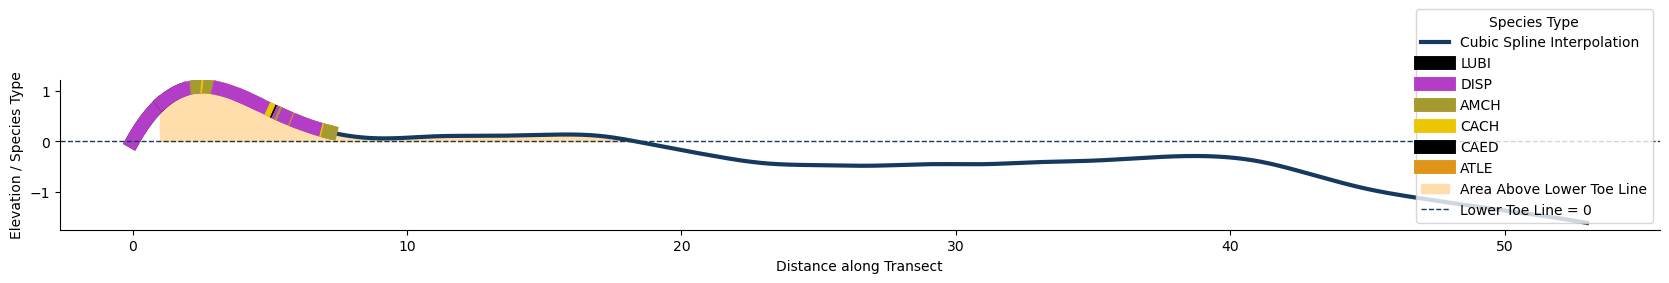

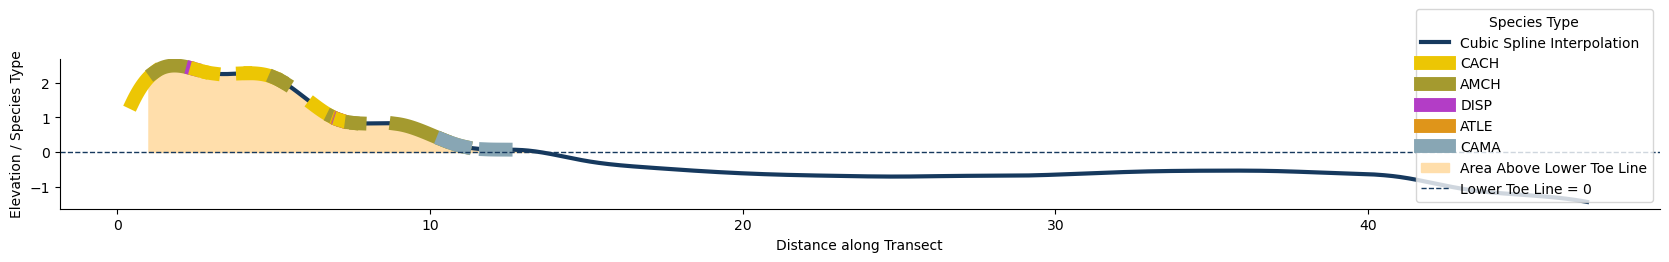

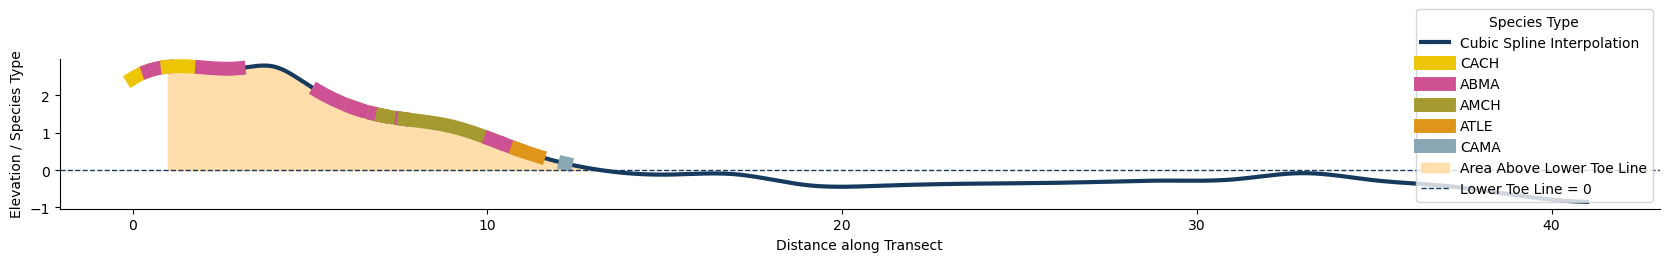

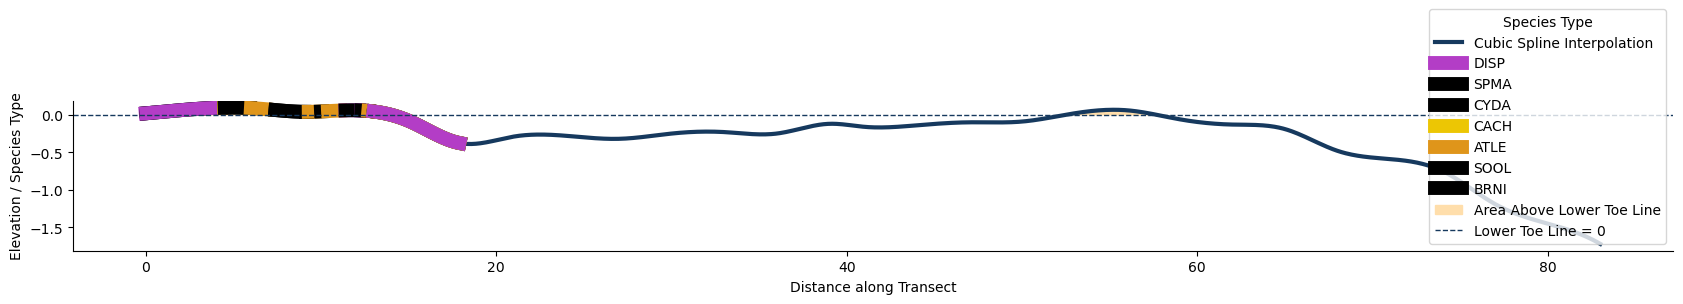

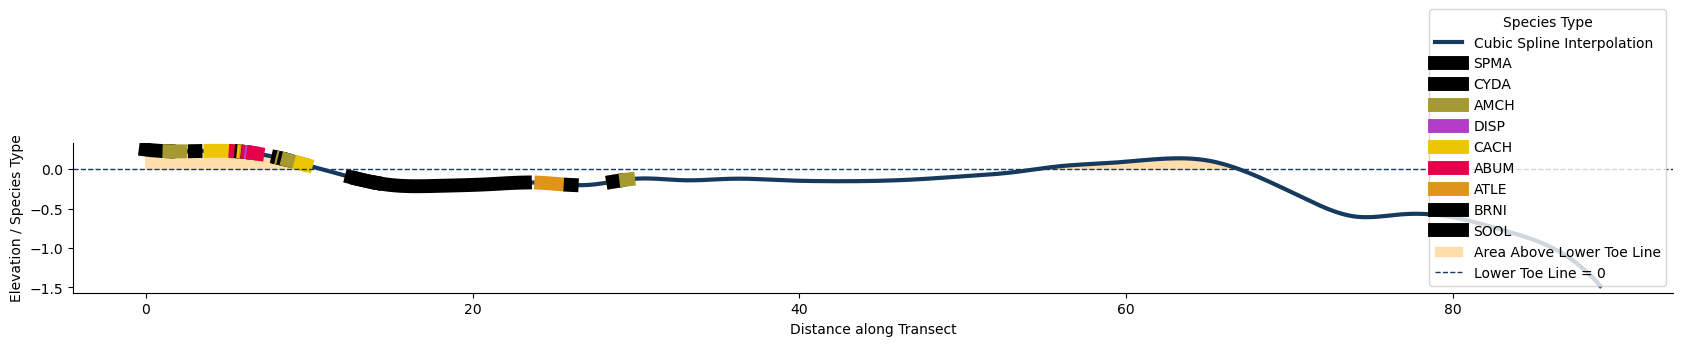

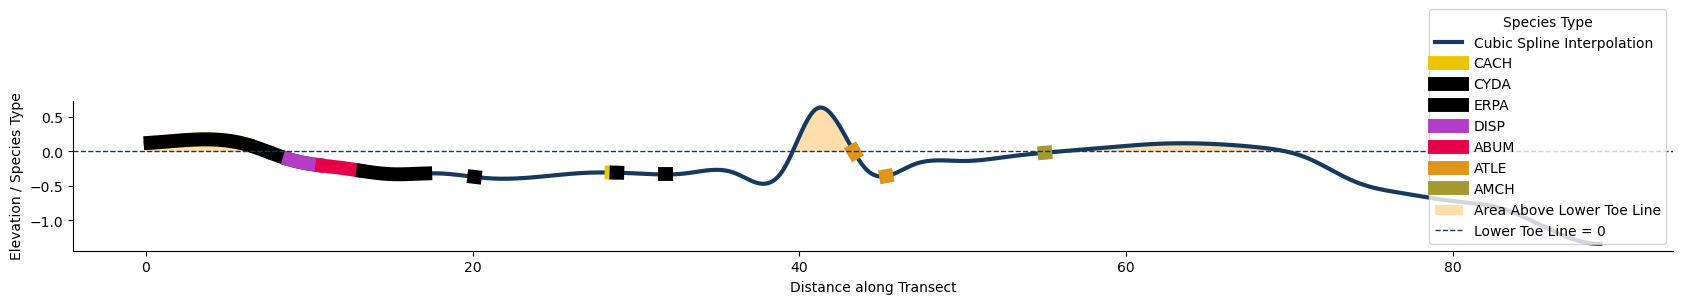

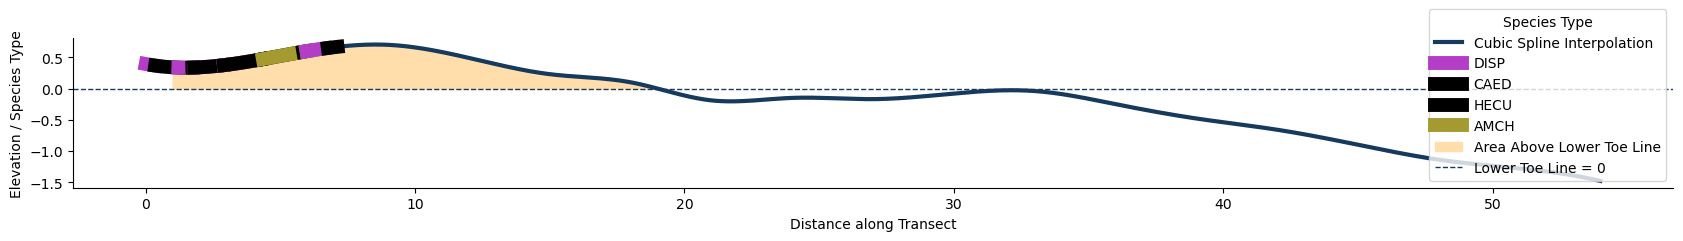

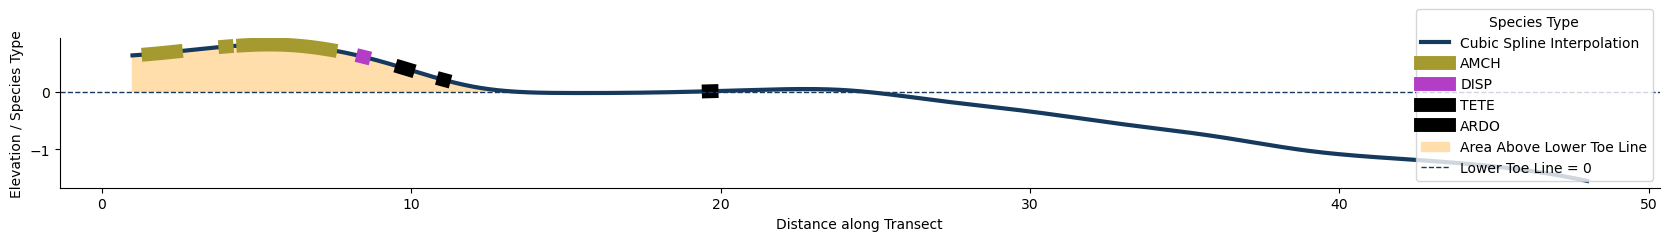

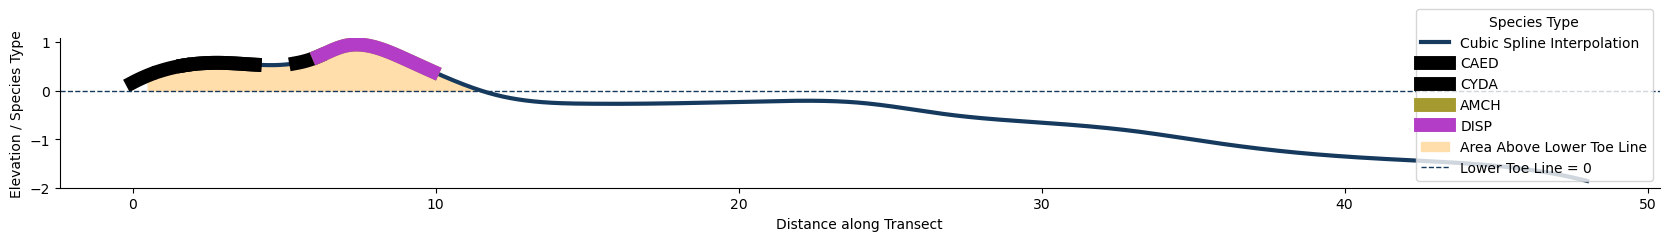

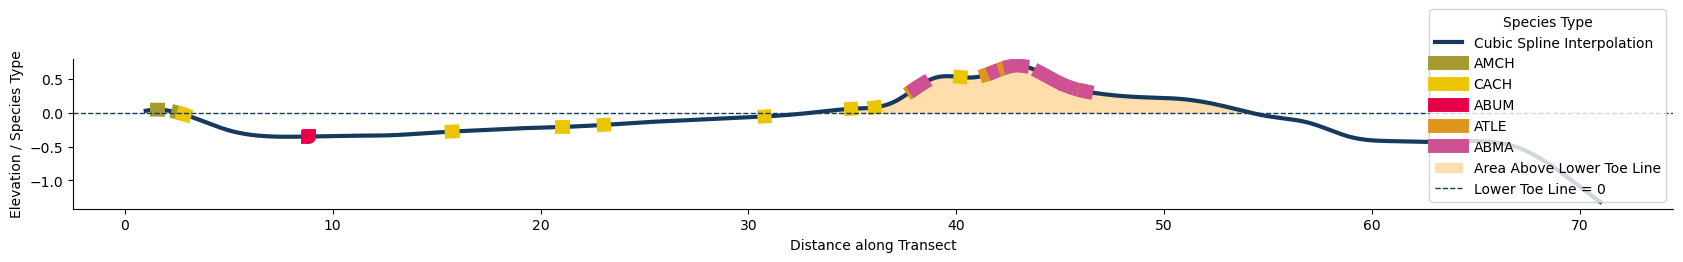

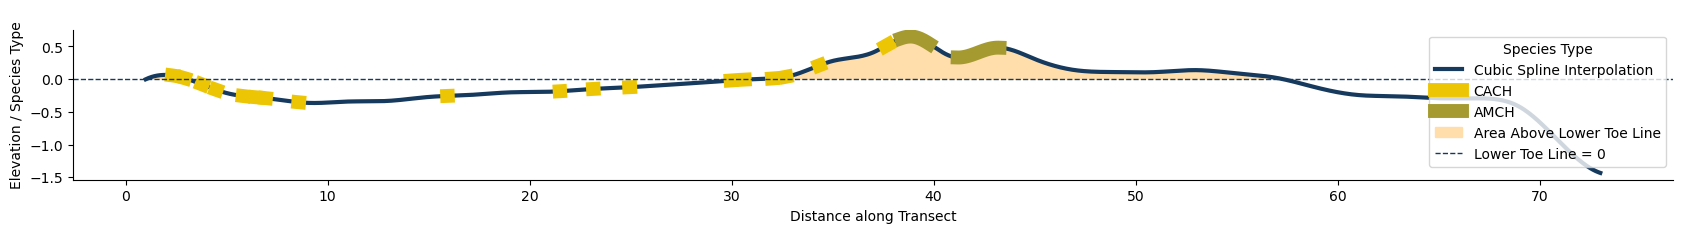

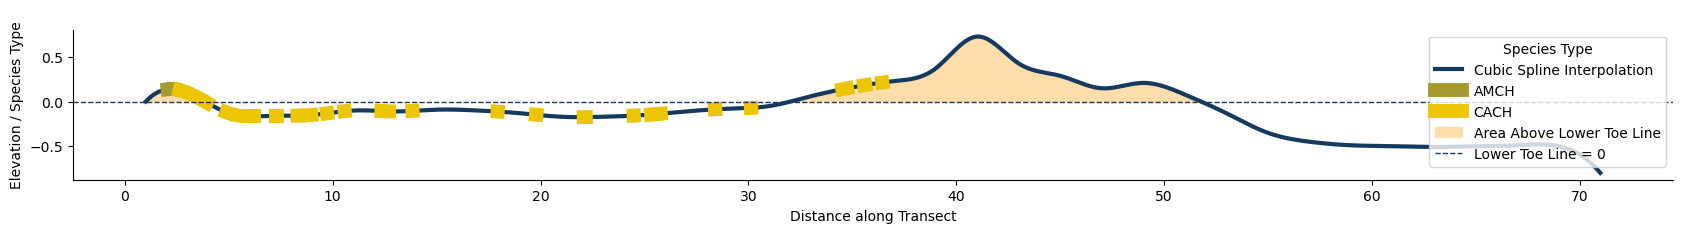

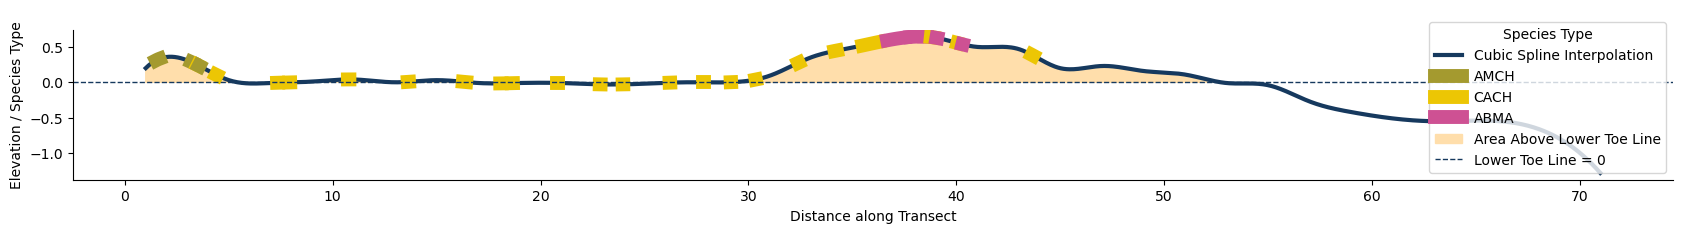

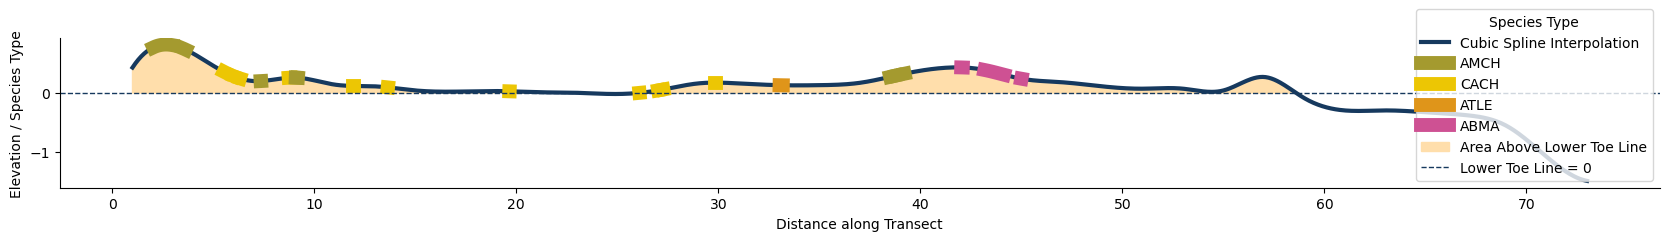

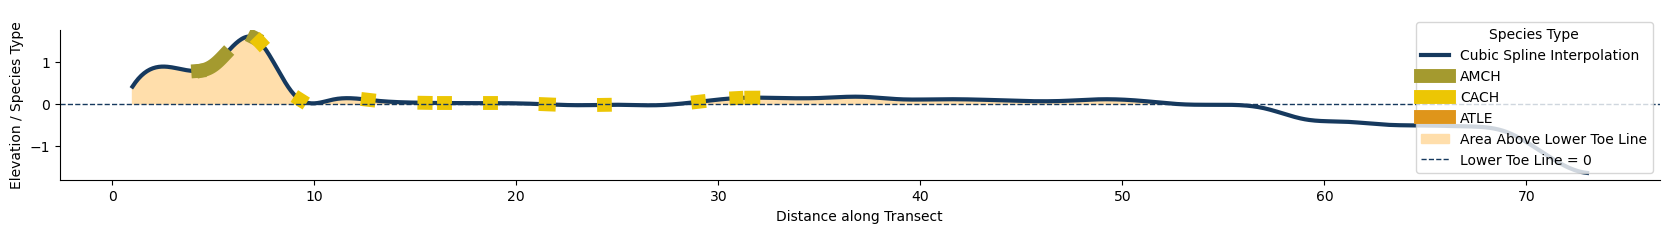

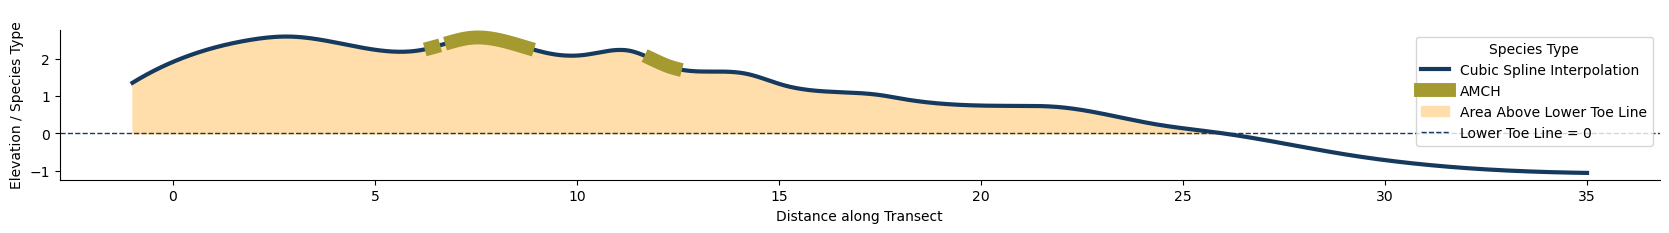

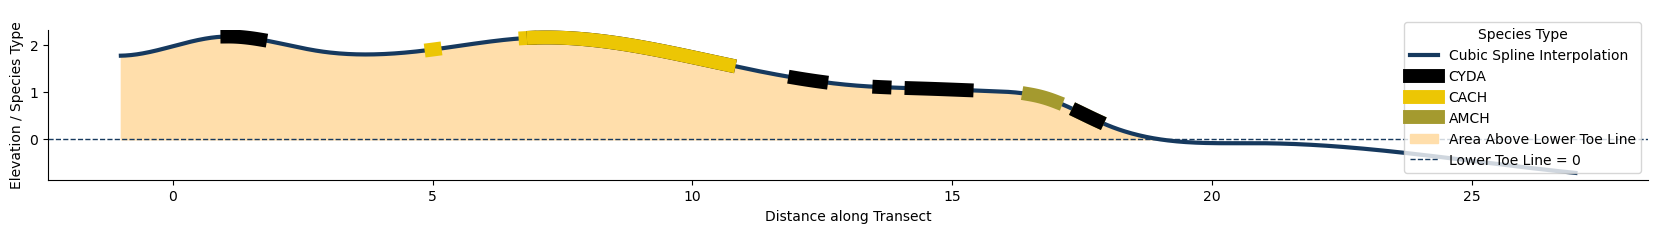

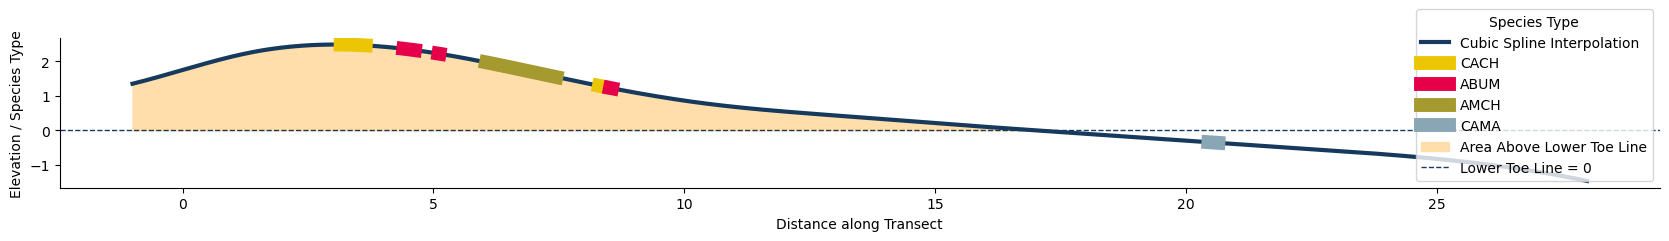

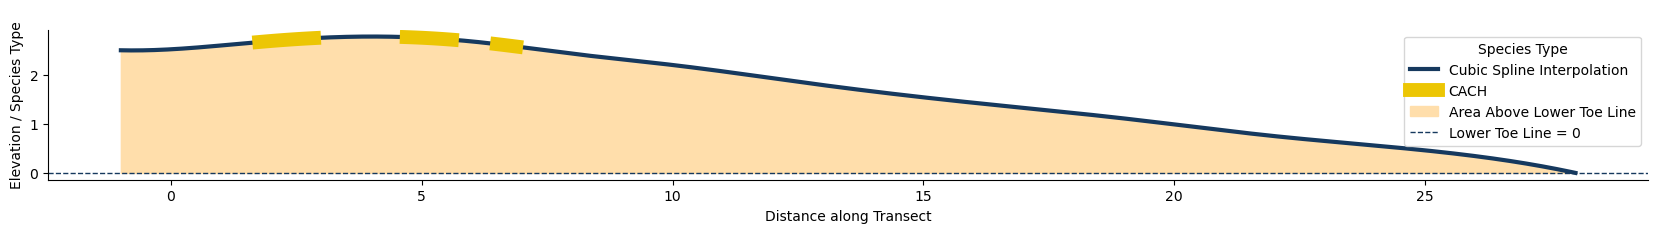

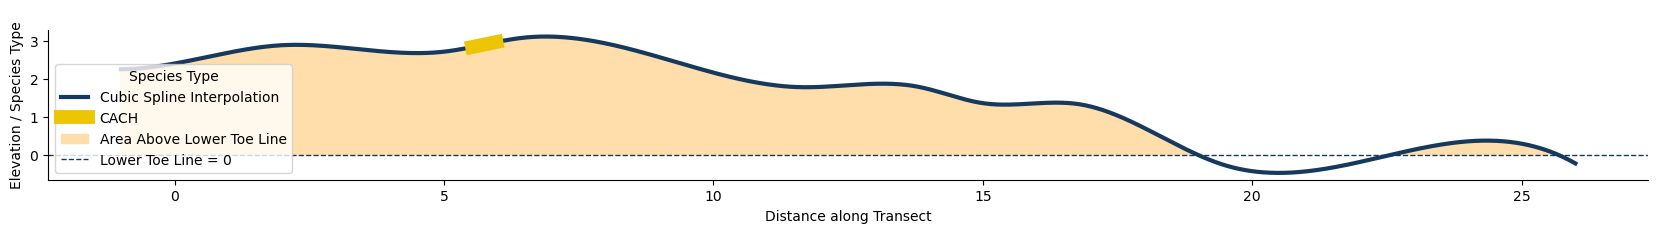

KeyboardInterrupt: 

In [8]:
# Execute the main function
if __name__ == "__main__":
    directory = "GoogleSheets"
    process_files(directory)